# PulsarPrediction

## Introduction

## Preliminary exploratory data analysis

### Importing libraries

In [31]:
suppressMessages(library(tidyverse))
suppressMessages(library(repr))
suppressMessages(library(tidymodels))
options(repr.matrix.max.rows = 6)

### Reading data
Data was downloaded from kaggle.com as CSV files. 
Kaggle provided training and testing data. It should be noted that Kaggle testing
data is unlabelled, so model evaluation must be done with some proportion of training
data.

In [44]:
pulsar_training = read_csv("pulsar_data_train.csv",col_types = cols())

print(paste("pulsar_training has", nrow(pulsar_training), "observations,"))
print(paste(ncol(pulsar_training), "variables, and"))
print(paste(sum(rowSums(is.na(pulsar_training)) > 0), "NA observations."))
print("Column names before shortening are: ")
for(n in names(pulsar_training)){
    print(n)
}

[1] "pulsar_training has 12528 observations,"
[1] "9 variables, and"
[1] "3255 NA observations."
[1] "Column names before shortening are: "
[1] "Mean of the integrated profile"
[1] "Standard deviation of the integrated profile"
[1] "Excess kurtosis of the integrated profile"
[1] "Skewness of the integrated profile"
[1] "Mean of the DM-SNR curve"
[1] "Standard deviation of the DM-SNR curve"
[1] "Excess kurtosis of the DM-SNR curve"
[1] "Skewness of the DM-SNR curve"
[1] "target_class"


### Shortening column names

In [45]:
pulsar_names = c()
for(n in names(pulsar_training)){
    acroynm = ''
    for(word in str_split(n, ' ')){
        acroynm = paste(acroynm,substr(word,1,1), sep = '', collapse='')
    }
    pulsar_names = c(pulsar_names,acroynm)
}
names(pulsar_training)<-pulsar_names
print("Column names after shortening are: ")
for(n in names(pulsar_training)){
    print(n)
}

[1] "Column names after shortening are: "
[1] "Motip"
[1] "Sdotip"
[1] "Ekotip"
[1] "Sotip"
[1] "MotDc"
[1] "SdotDc"
[1] "EkotDc"
[1] "SotDc"
[1] "t"


### Removing NA entries

In [48]:
pulsar_training = na.omit(pulsar_training)
print(paste("pulsar_training has", nrow(pulsar_training), "observations,"))
print(paste(ncol(pulsar_training), "variables, and"))
print(paste(sum(rowSums(is.na(pulsar_training)) > 0), "NA observations."))

[1] "pulsar_training has 9273 observations,"
[1] "9 variables, and"
[1] "0 NA observations."


### Data summary and visualization

The goal of this summary will both be to get a general feel for the data, but more importantly to serve as guidance for feature selection, so we will be
splitting the data into positive and negative cases for a more accurate depiction of the data, since there are approximately 10 times more negative cases, which will heavily influence the overall summary and visualization.


In [12]:
# Data split
pulsar_pos = pulsar_training %>%
filter(t == 1)

pulsar_neg = pulsar_training %>%
filter(t == 0)

In [46]:
# Create plots
pulsar_plot = gather(pulsar_training) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='darkblue')+
facet_wrap(~key, scales = 'free_x')

pulsar_pos_plot = gather(pulsar_pos) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='coral')+
facet_wrap(~key, scales = 'free_x')

pulsar_neg_plot = gather(pulsar_neg) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='dodgerblue')+
facet_wrap(~key, scales = 'free_x')

#### Overall plot

We can see that EkotDc, Motip, and Sdotip have roughly normal distributions, but the rest are all skewed to the right.

Warning message:
“Removed 3538 rows containing non-finite values (stat_bin).”


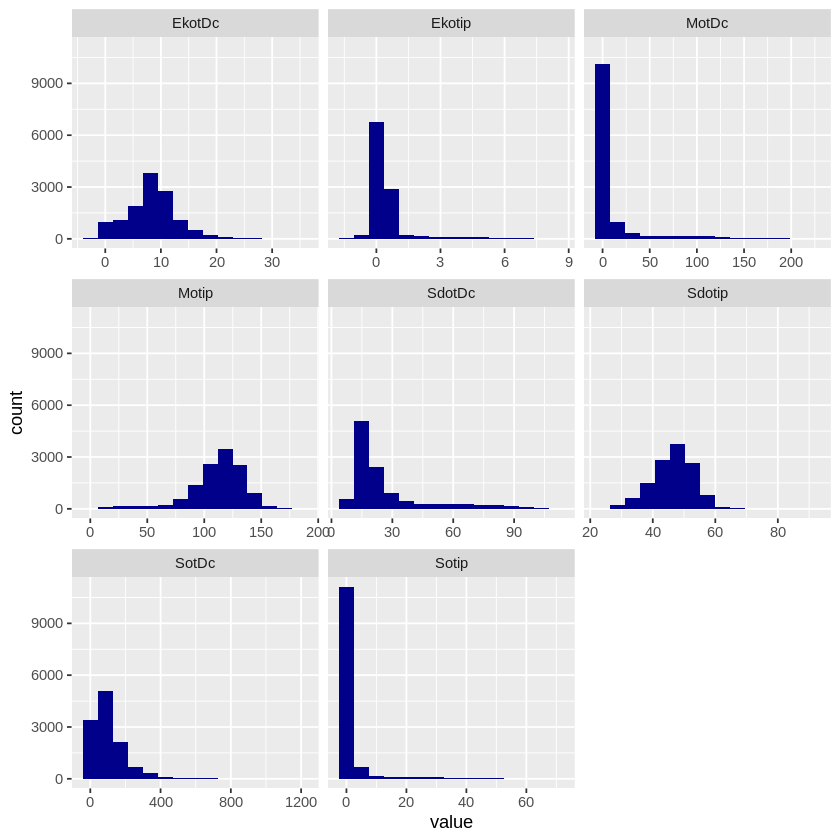

In [49]:
pulsar_plot

#### Negative plots

Because of just how much negative data there is, the overall plot looks essentially identical to the plot with only negative cases.

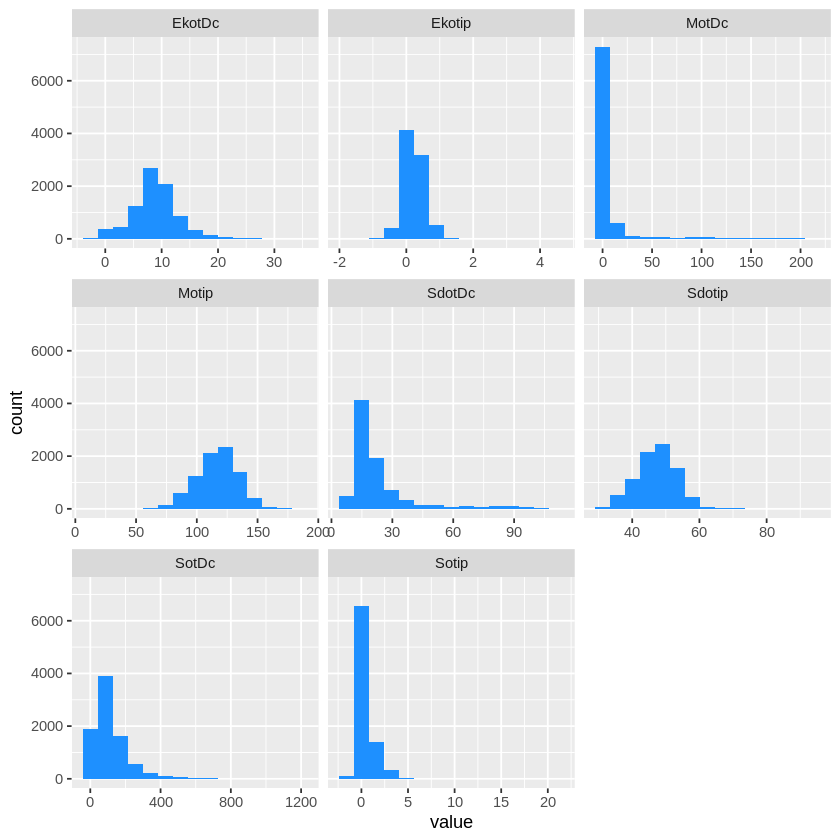

In [50]:
pulsar_neg_plot

#### Positive plots

The positive plots are dramatically different from both the overall and negative plots. The most different ones are Ekotip, Motip, and SdotDc on account of their different skews and variances.

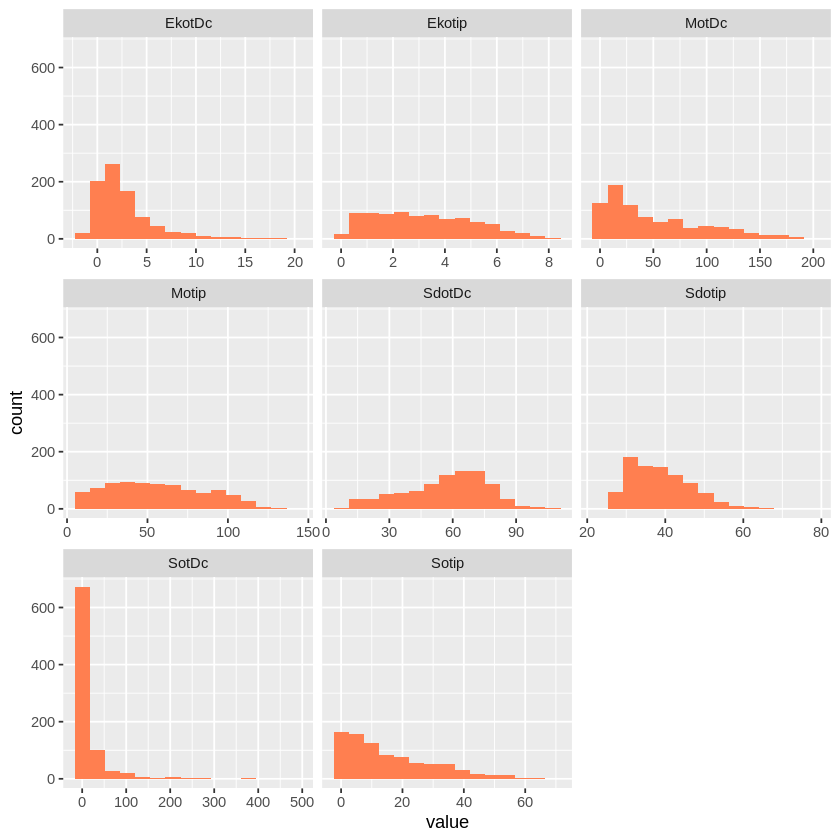

In [52]:
pulsar_pos_plot

#### Comparison of statistical attributes

Here we will compare and contrast the mean, median, and standard deviation of each attribute of both classes.

In [93]:
# Part 1 - Getting means and stdev

posmeans = pulsar_pos %>% 
map_df(mean) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc)
names(posmeans) <- c("name", "pos_mean")

posdev = pulsar_pos %>% 
map_df(sd) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc) %>%
select(-name)
names(posdev) <- c("pos_stdev")

negmeans = pulsar_neg %>% 
map_df(mean) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc)%>%
select(-name)
names(negmeans) <- c("neg_mean")

negdev = pulsar_neg %>% 
map_df(sd) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc) %>%
select(-name)
names(negdev) <- c("neg_stdev")

summarized = cbind(posmeans,posdev, negmeans,negdev)
summarized %>% head(4)
summarized %>% tail(4)

,name,pos_mean,pos_stdev,neg_mean,neg_stdev
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Motip,56.490790,29.840725,116.6479988,17.4600853
2,Sdotip,38.653987,7.974646,47.3072449,6.1116413
3,Ekotip,3.146134,1.894812,0.2104498,0.3334176
4,Sotip,15.736526,14.396040,0.3833387,1.0040248


,name,pos_mean,pos_stdev,neg_mean,neg_stdev
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,MotDc,50.874638,45.938321,8.886566,24.51792
6,SdotDc,56.664961,19.746352,23.266417,16.70009
7,EkotDc,2.737318,3.085782,8.892105,4.28467
8,SotDc,17.793435,46.167913,114.662773,108.65428


[1] 1.07357

name,mean_diff,stdev_bigger
<chr>,<dbl>,<dbl>
Sdotip,0.1829161,8.561343
Motip,0.5157157,32.036114
SdotDc,0.5894038,21.199096
⋮,⋮,⋮
SotDc,0.8448194,116.647999
Ekotip,0.9331085,2.034213
Sotip,0.9756402,15.455160


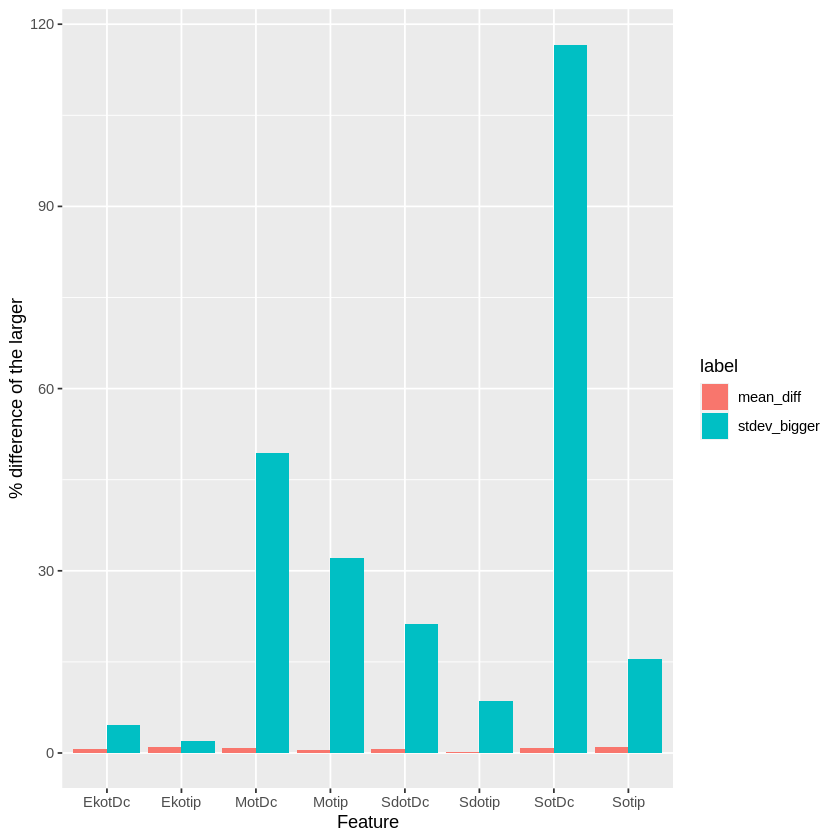

In [108]:
(max(c(summarized$pos_mean,summarized$neg_mean))/max(c(summarized$pos_stdev, summarized$neg_stdev)))
# Part 2 - Finding percentage difference of the larger
percent_diff = summarized %>%
mutate(mean_diff = case_when(pos_mean > neg_mean ~ (pos_mean - neg_mean)/pos_mean, TRUE ~ (neg_mean - pos_mean)/neg_mean)) %>%
mutate(stdev_bigger = case_when(pos_stdev > neg_stdev ~ pos_stdev, TRUE ~ neg_stdev) * (max(c(pos_mean,neg_mean))/max(c(pos_stdev, neg_stdev)))) %>%
select(name, mean_diff,stdev_bigger) %>%
arrange(mean_diff)
percent_diff

# Part 3 - Plotting percange difference
percent_diff_plot <- percent_diff %>%
pivot_longer(cols=mean_diff:stdev_bigger, names_to="label") %>%
ggplot(aes(x=name, y=value, fill=label))+
geom_bar(position="dodge",  stat="identity")+
labs(x="Feature", y="% difference of the larger")
percent_diff_plot

**Interpretation**
This analysis is meant to assist in feature selection. Here I have calculated the means and standard deviation in Part 1, then found the percentage mean difference between positive and negative cases. The formula for this is:

$$ \frac{|\mu_{pos} - \mu_{neg}|}{max(\mu_{pos},\mu_{neg})} $$

In [95]:
# aov(t ~ Motip, data=pulsar_training)
summary(aov(t ~ Motip, data=pulsar_training))
# residuals(aov(t ~ Motip, data=pulsar_training))
aov.models = pulsar_training %>%
  map(~ summary(aov(pulsar_training$t ~ .x))[[1]][["F value"]][1])

as_tibble(aov.models) %>%
pivot_longer(cols=Motip:t, names_to="predictor") %>%
filter(predictor != 't') %>%
arrange(desc(value)) %>%
head(4)

summary(aov(t ~ Motip + Ekotip + Sotip + SdotDc, data=pulsar_training))
summary(aov(t ~ Motip + Ekotip + Sotip + MotDc + SdotDc + SotDc, data=pulsar_training))
summary(aov(t ~ ., data=pulsar_training))

              Df Sum Sq Mean Sq F value Pr(>F)    
Motip          1  352.6   352.6    7794 <2e-16 ***
Residuals   9271  419.4     0.0                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

predictor,value
<chr>,<dbl>
Ekotip,15482.646
Sotip,9148.079
Motip,7794.219
SdotDc,2979.422


              Df Sum Sq Mean Sq F value Pr(>F)    
Motip          1  352.6   352.6 13154.0 <2e-16 ***
Ekotip         1  130.9   130.9  4884.1 <2e-16 ***
Sotip          1   23.7    23.7   885.2 <2e-16 ***
SdotDc         1   16.3    16.3   609.1 <2e-16 ***
Residuals   9268  248.5     0.0                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq   F value Pr(>F)    
Motip          1  352.6   352.6 13277.278 <2e-16 ***
Ekotip         1  130.9   130.9  4929.838 <2e-16 ***
Sotip          1   23.7    23.7   893.463 <2e-16 ***
MotDc          1    4.1     4.1   153.622 <2e-16 ***
SdotDc         1   14.5    14.5   544.457 <2e-16 ***
SotDc          1    0.1     0.1     5.563 0.0184 *  
Residuals   9266  246.1     0.0                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq   F value  Pr(>F)    
Motip          1  352.6   352.6 13304.162 < 2e-16 ***
Sdotip         1    0.0     0.0     1.676 0.19555    
Ekotip         1  133.1   133.1  5020.911 < 2e-16 ***
Sotip          1   21.6    21.6   814.438 < 2e-16 ***
MotDc          1    4.6     4.6   174.170 < 2e-16 ***
SdotDc         1   14.3    14.3   539.673 < 2e-16 ***
EkotDc         1    0.1     0.1     2.742 0.09778 .  
SotDc          1    0.2     0.2     7.311 0.00687 ** 
Residuals   9264  245.5     0.0                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1